# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

  Running setup.py bdist_wheel for JSAnimation ... done
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation
using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



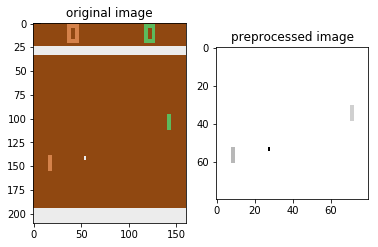

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # output = 20x20 here
#        self.conv = nn.Conv2d(2, 1, kernel_size=4, stride=4)
#        size_conv = (80-4+4)/4

        self.conv1 = nn.Conv2d(2, 4, kernel_size=3, stride=1) #78
        self.conv2 = nn.Conv2d(4, 8, kernel_size=4, stride=2) #39
        self.conv3 = nn.Conv2d(8, 16, kernel_size=5, stride=2) #18
        self.conv4 = nn.Conv2d(16, 32, kernel_size=4, stride=2) #8
#        size_conv = (80-4+4)/4

        self.size=1568#32*8*8
        
        # 1 fully connected layer
#        self.fc = nn.Linear(self.size, 1)
        
        self.fc1 = nn.Linear(self.size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        # flatten the tensor
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.sig(x)

# run your own policy!
policy=Policy().to(device)
#policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


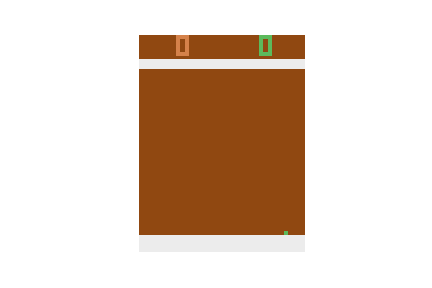
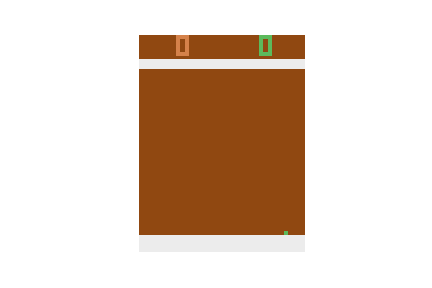
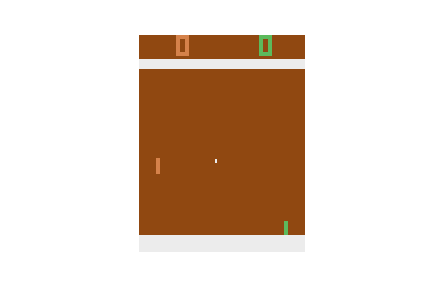
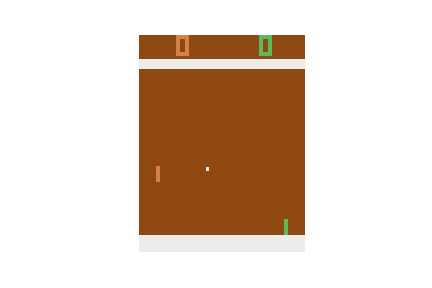
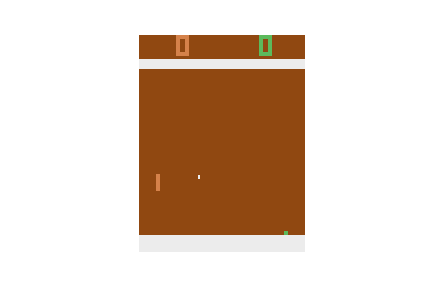
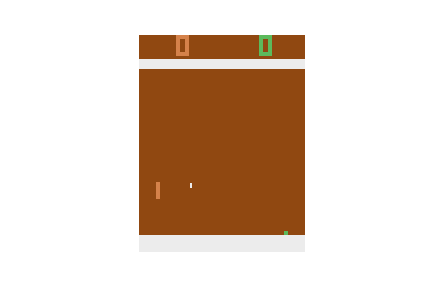
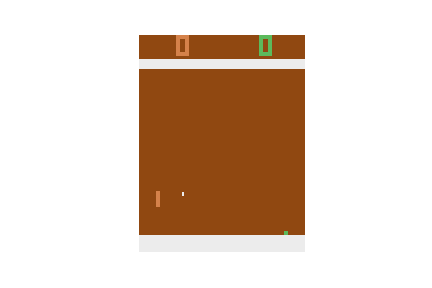
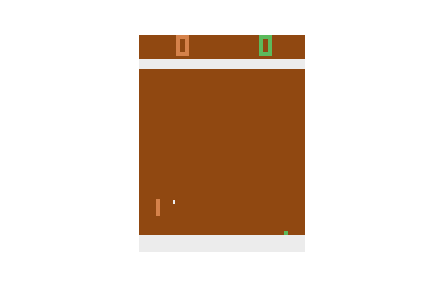
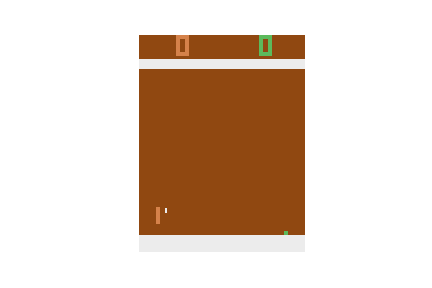
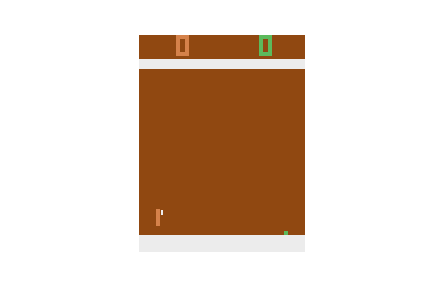
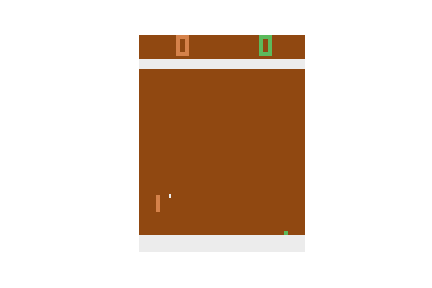
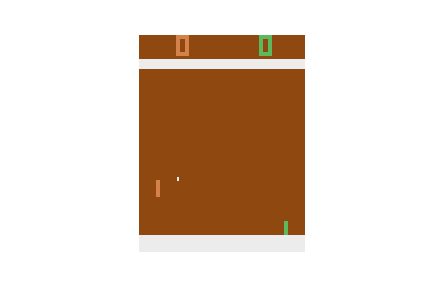
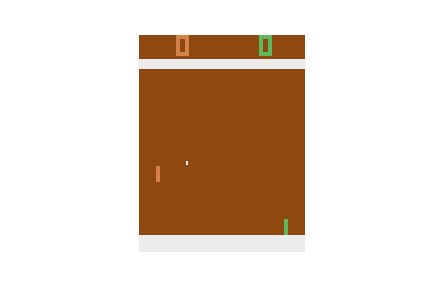
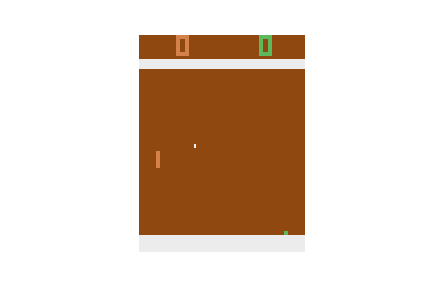
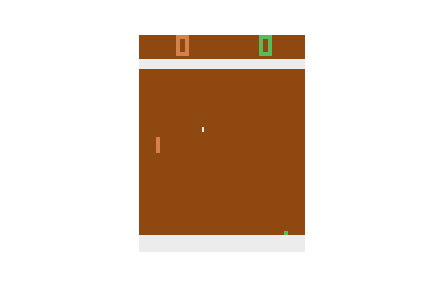
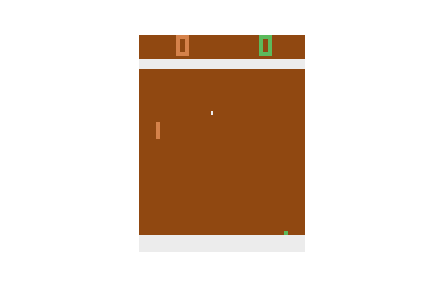
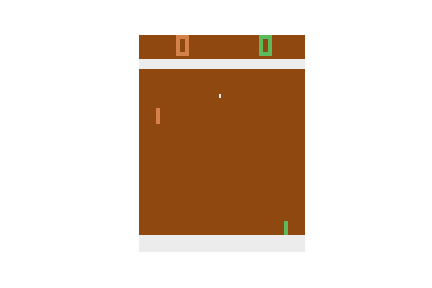
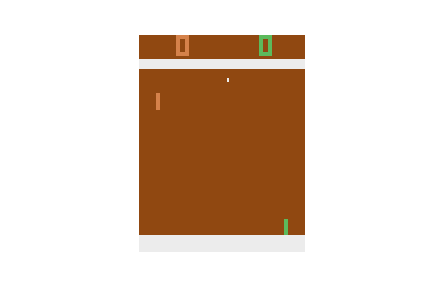
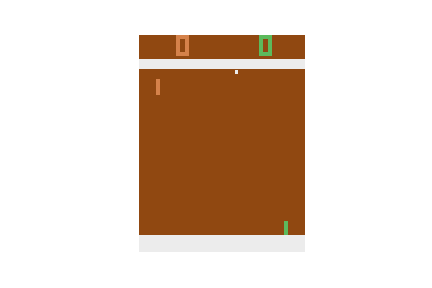
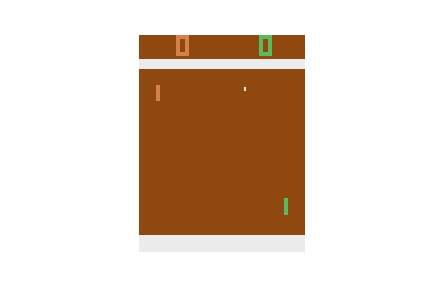
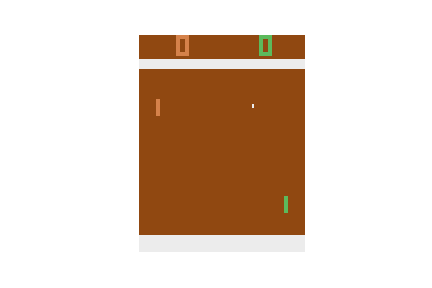
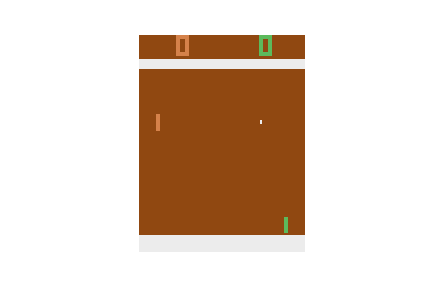
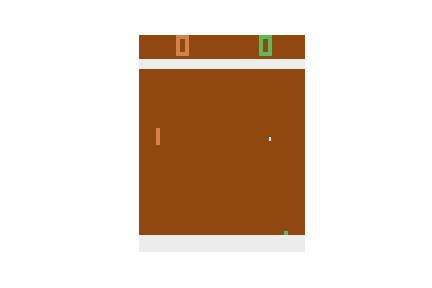
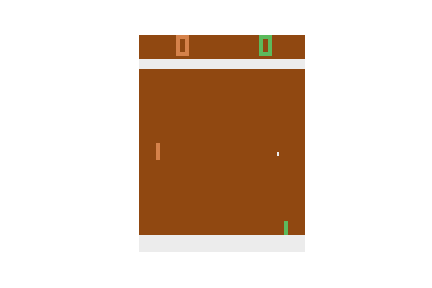
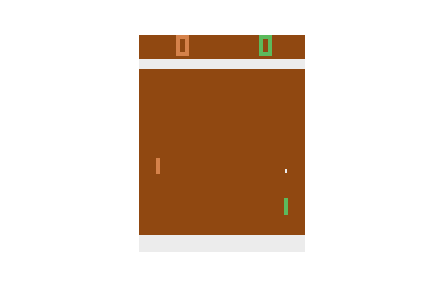
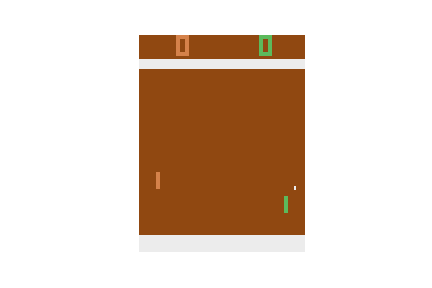
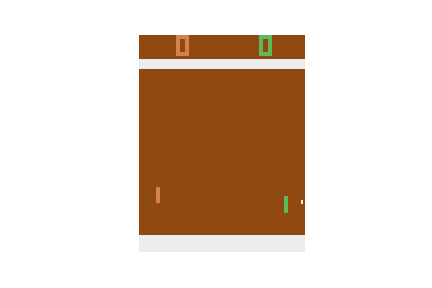
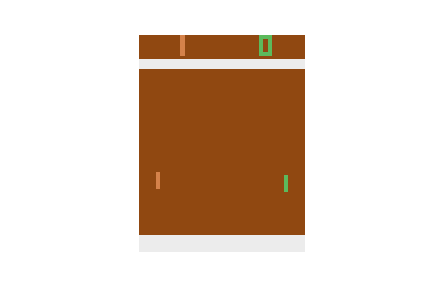
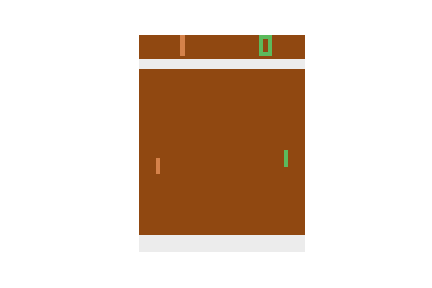
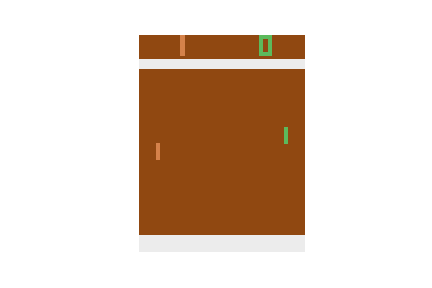
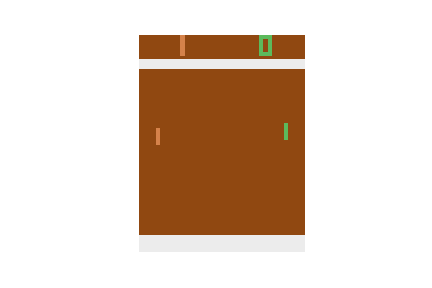
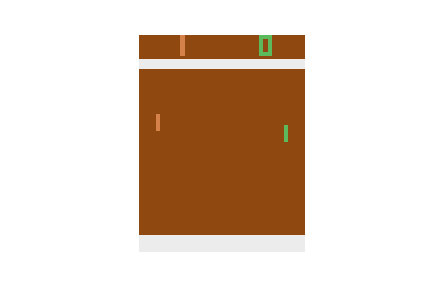
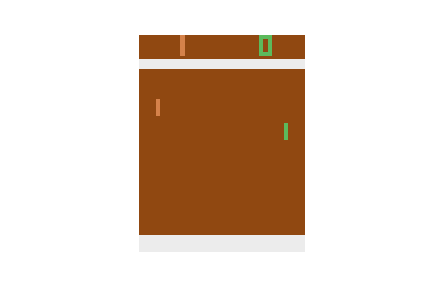
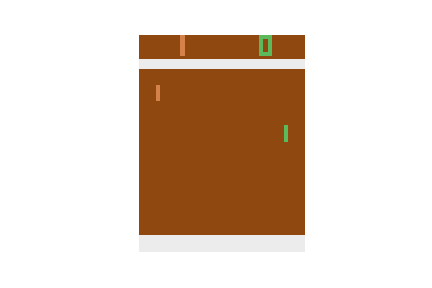
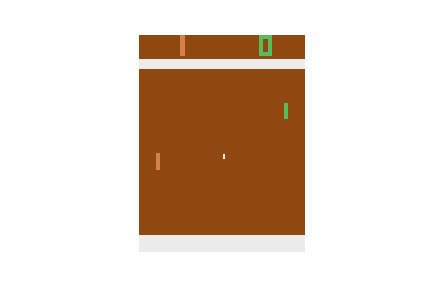
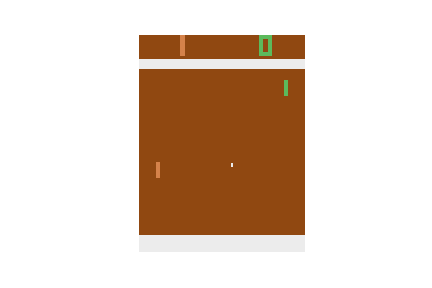
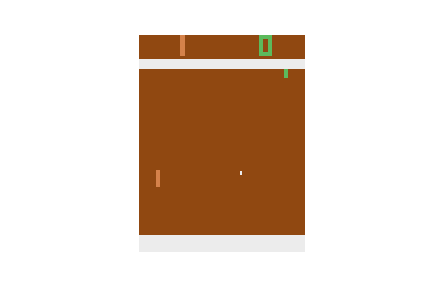
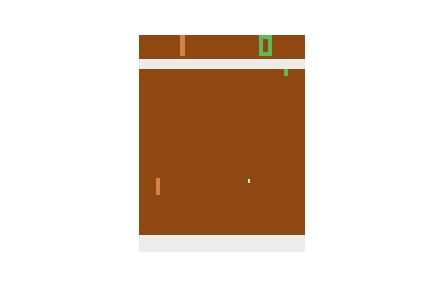
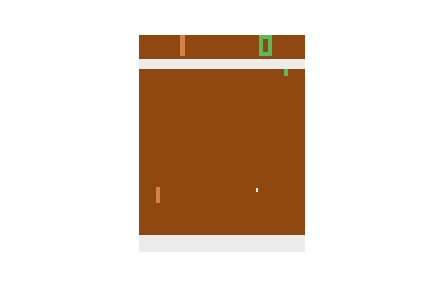
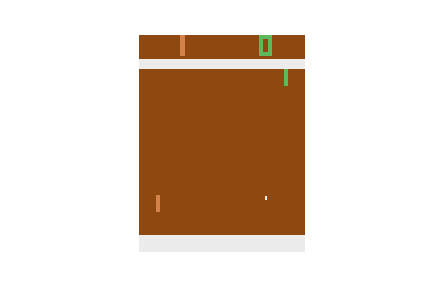
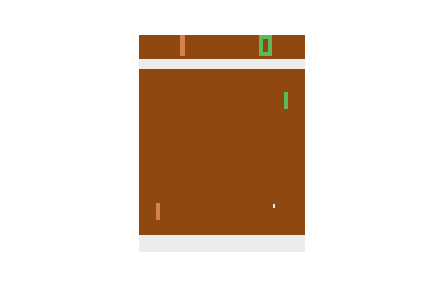
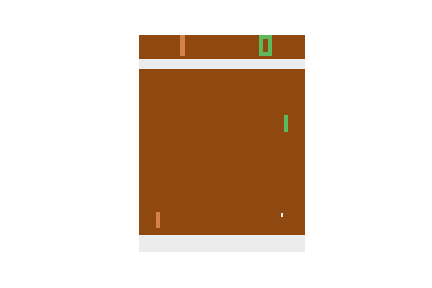
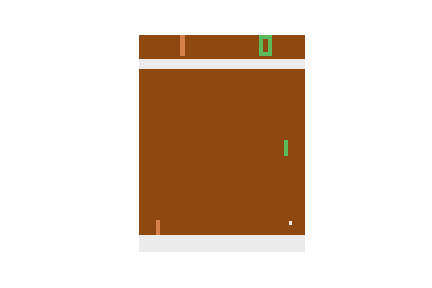
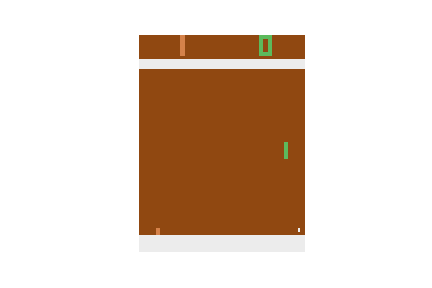
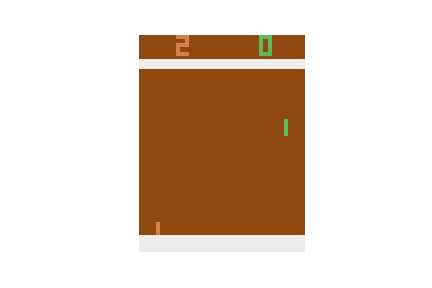
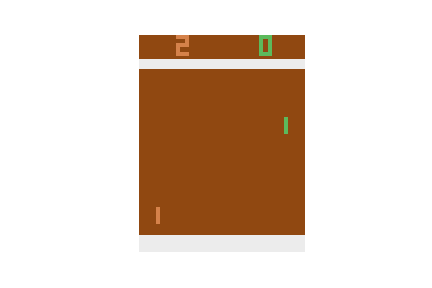
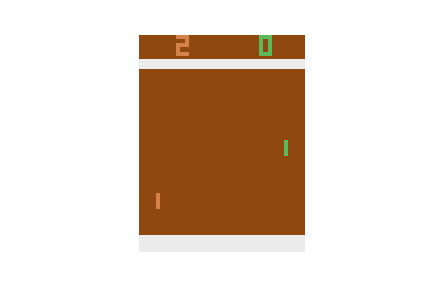
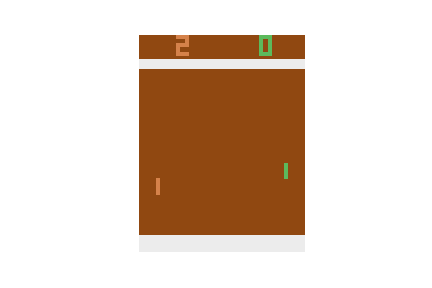
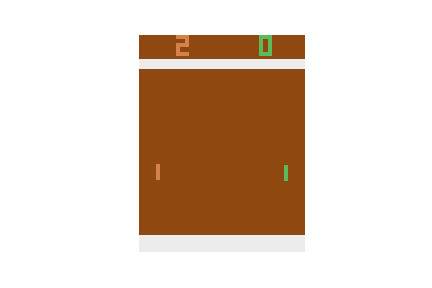
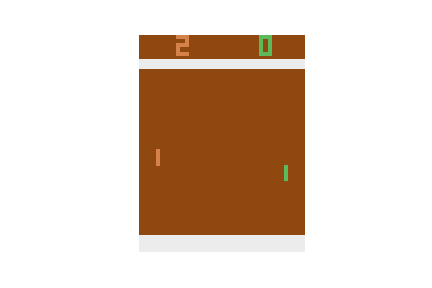
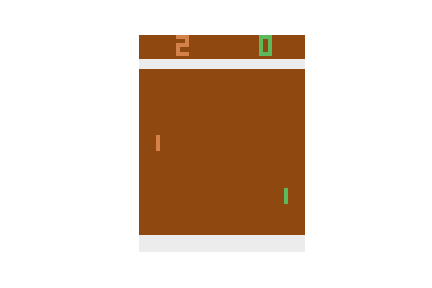
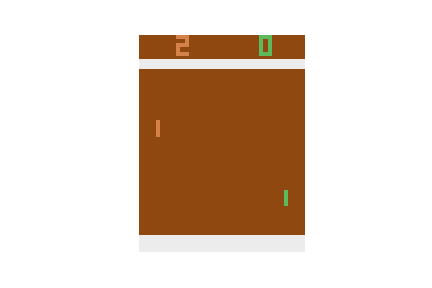
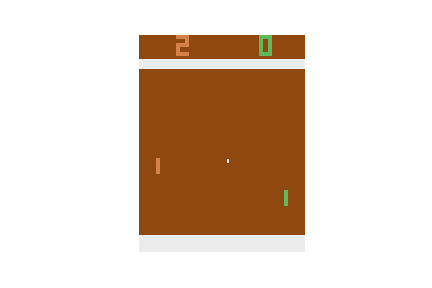
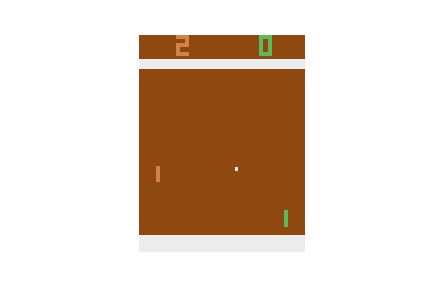
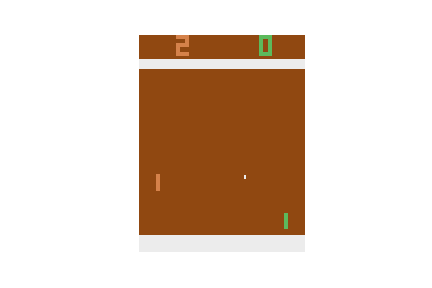
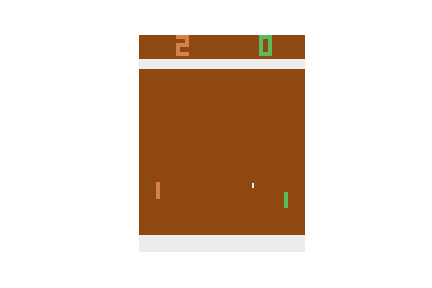
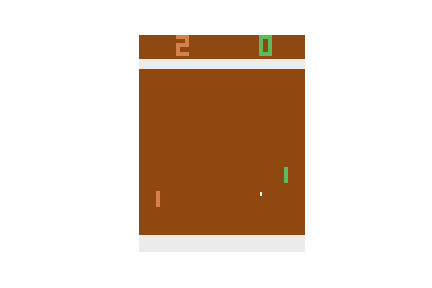
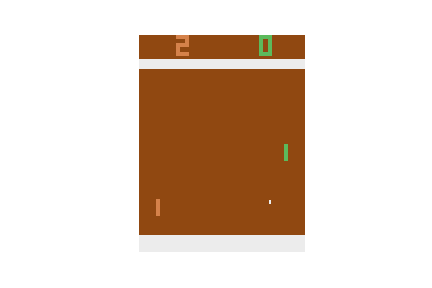
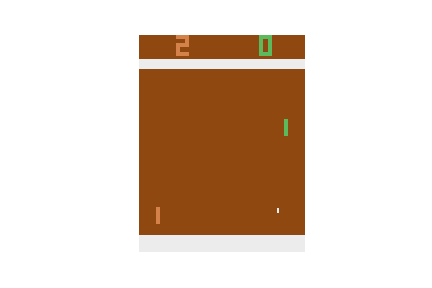
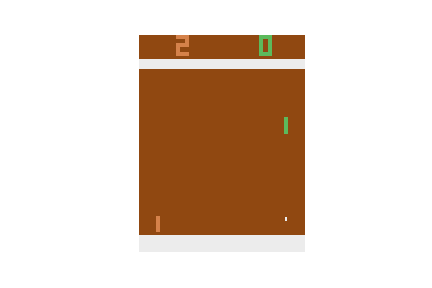
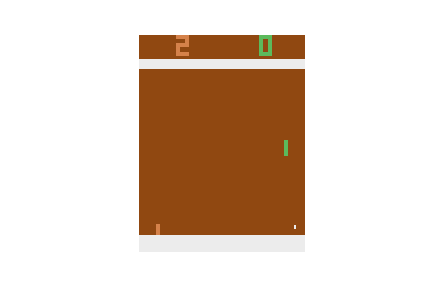
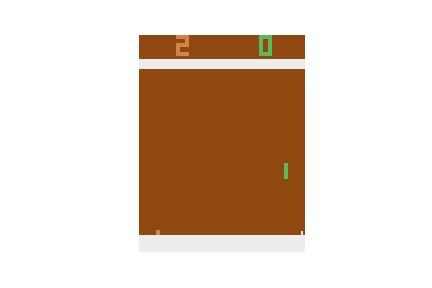
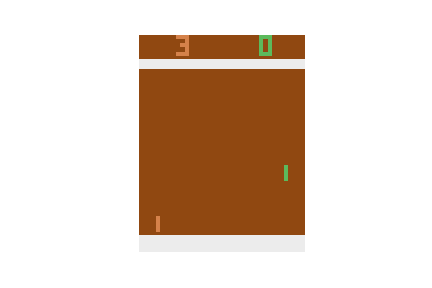
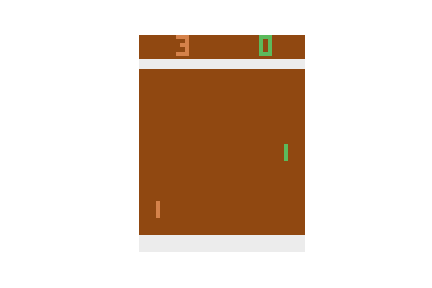
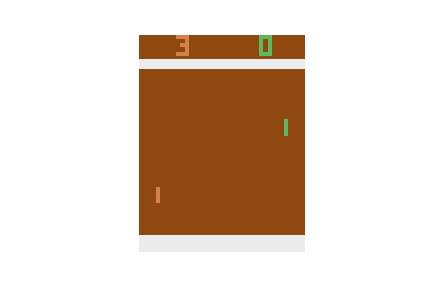
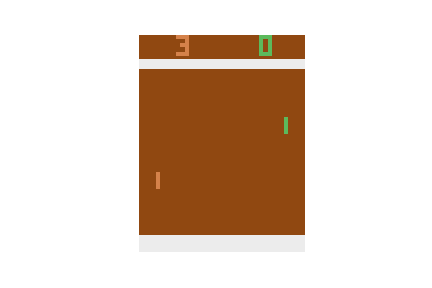
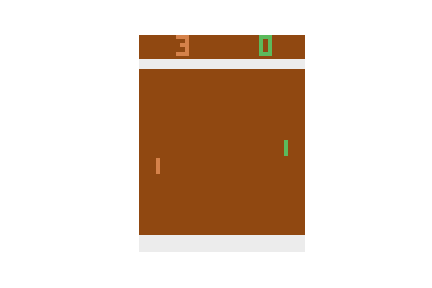
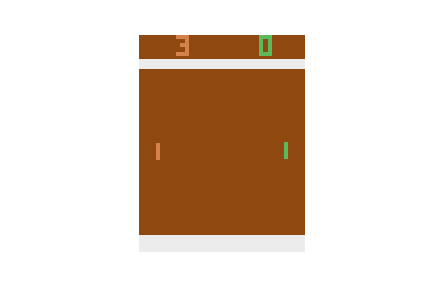
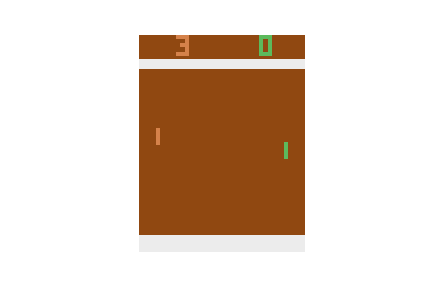
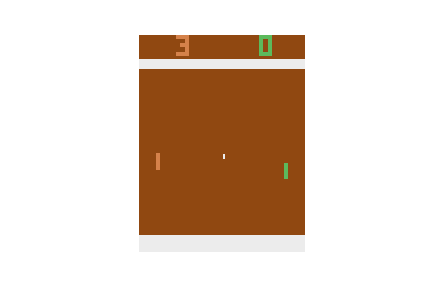
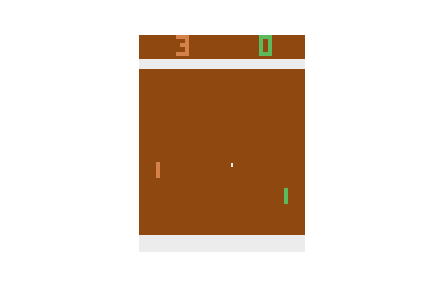
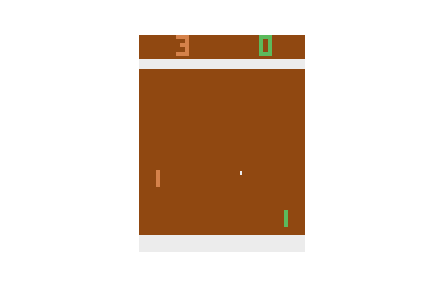
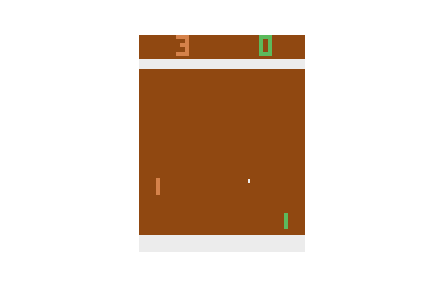
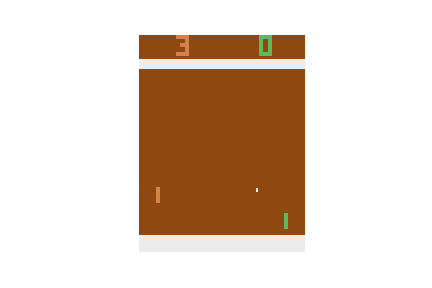
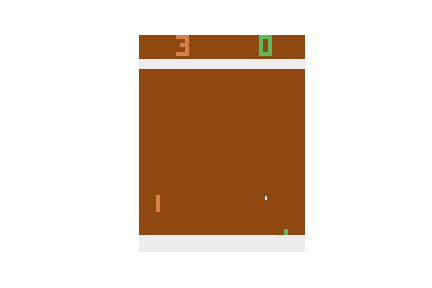
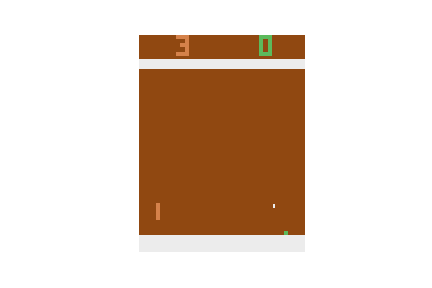
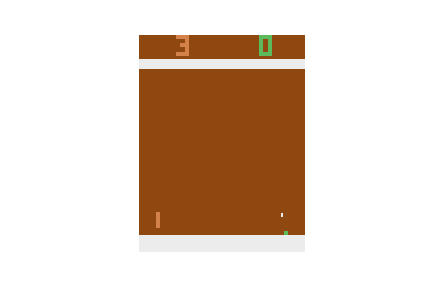
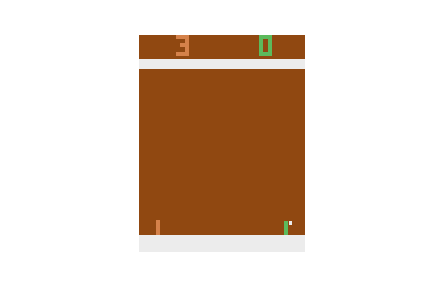
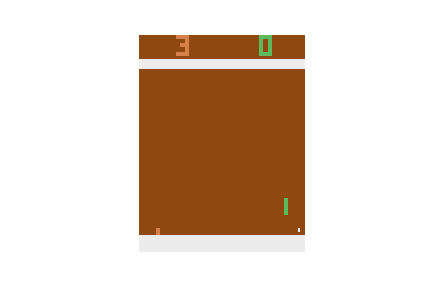
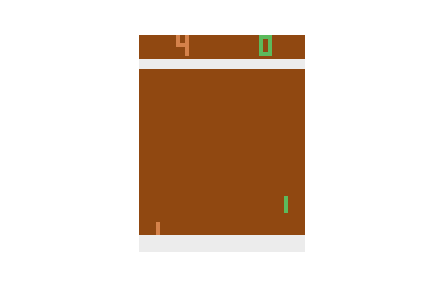
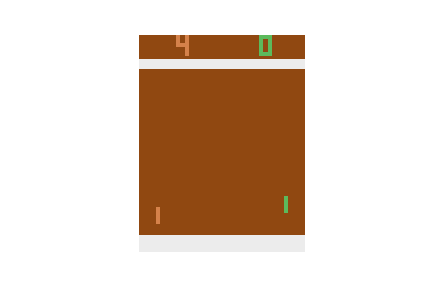
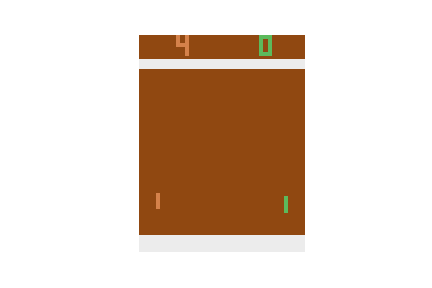
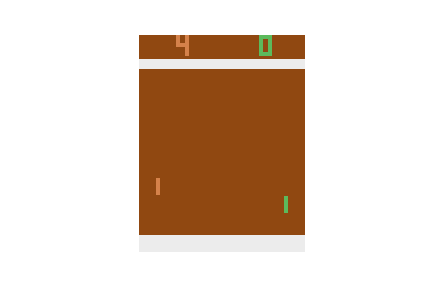
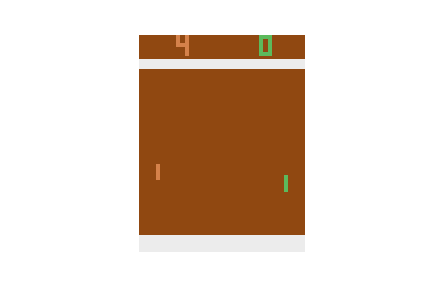
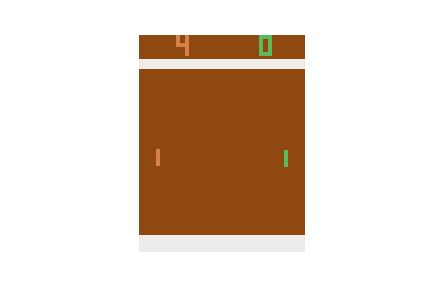
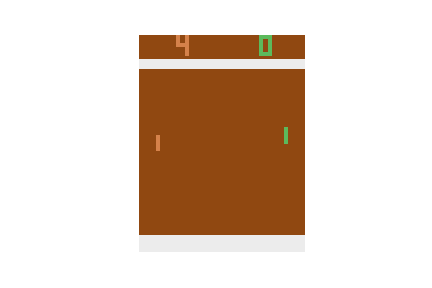
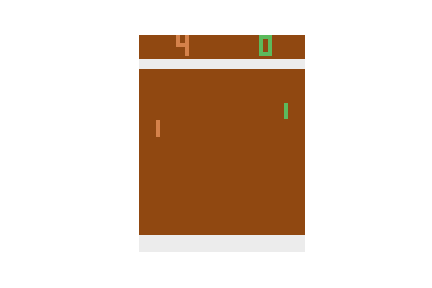
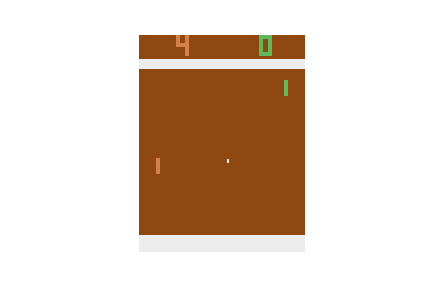
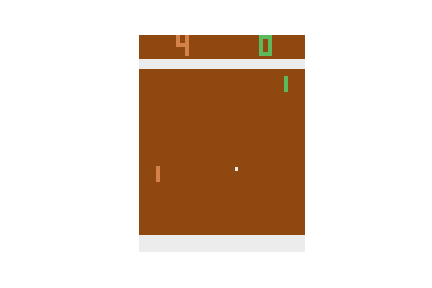
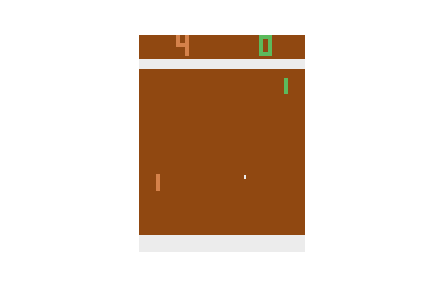
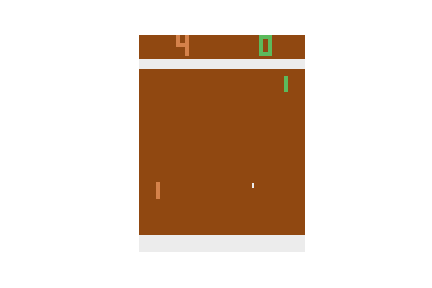
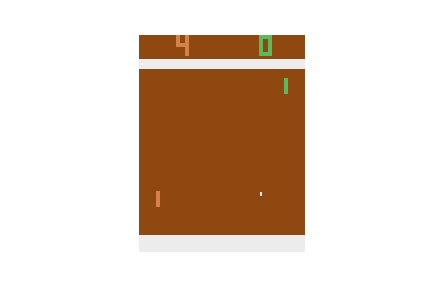
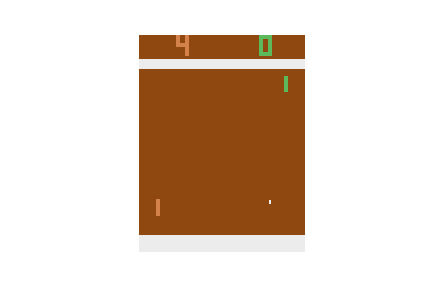
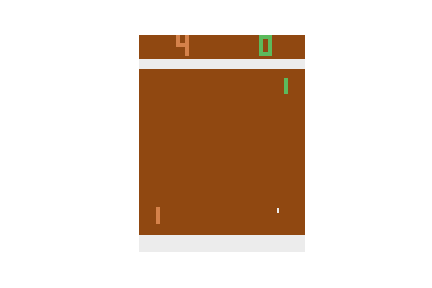
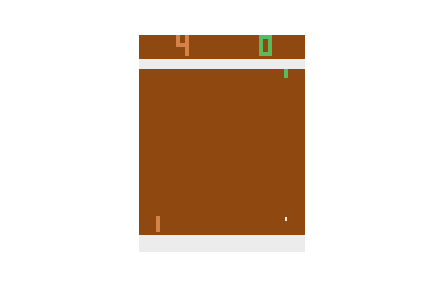
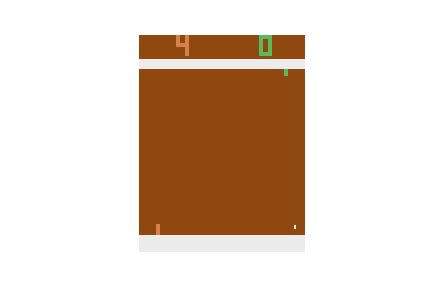
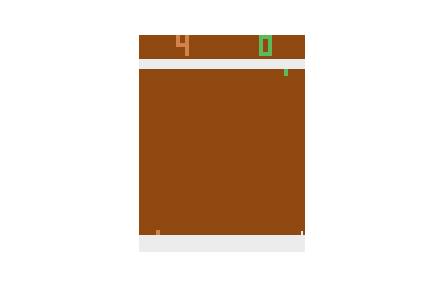
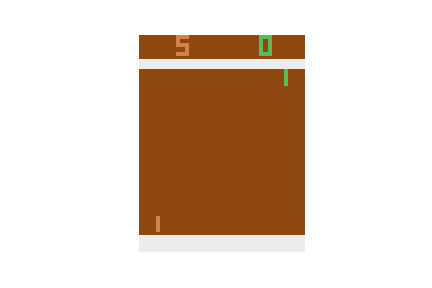
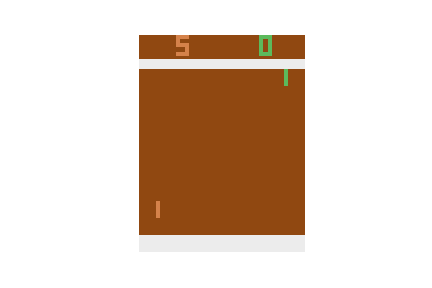
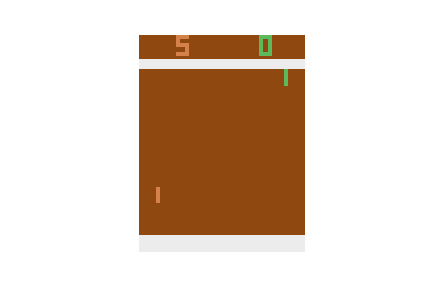
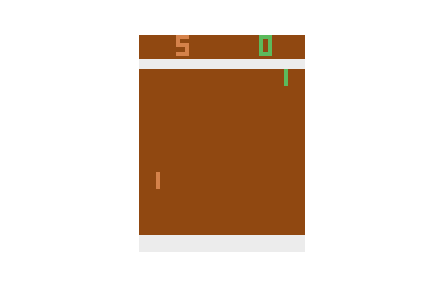
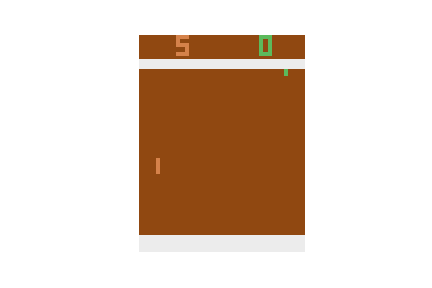
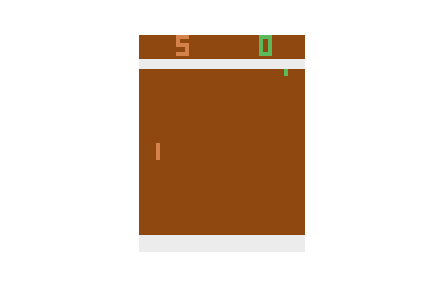
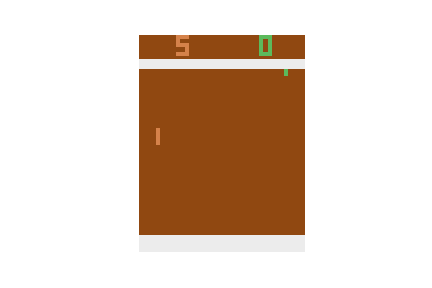
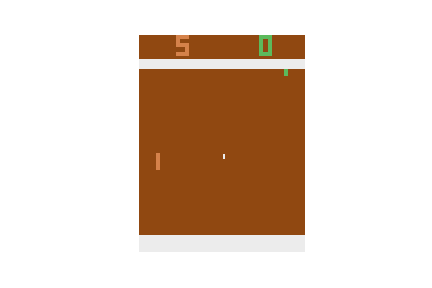
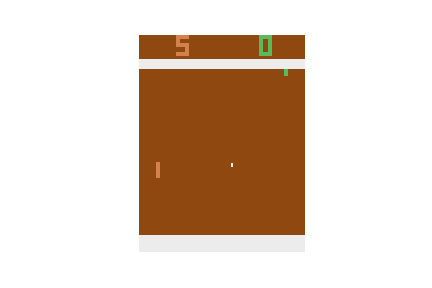
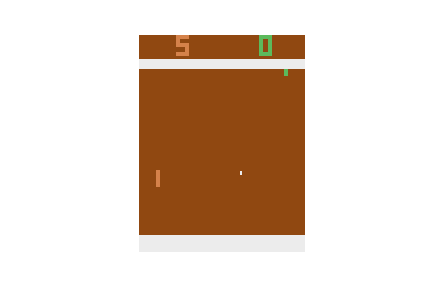
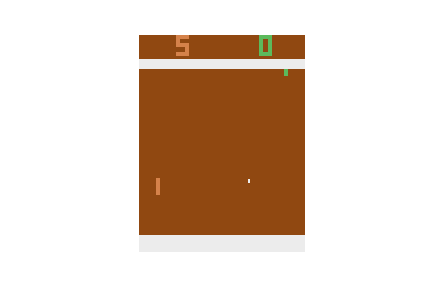
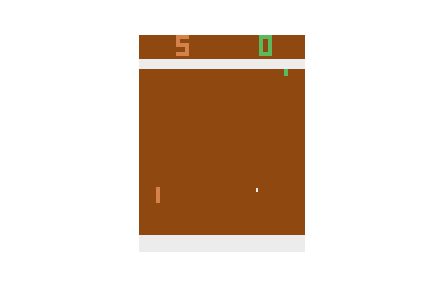
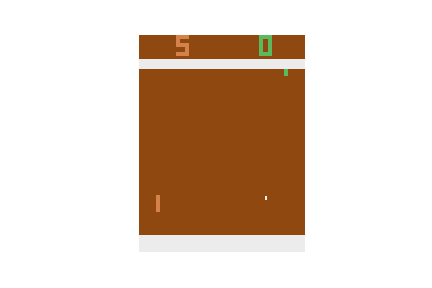
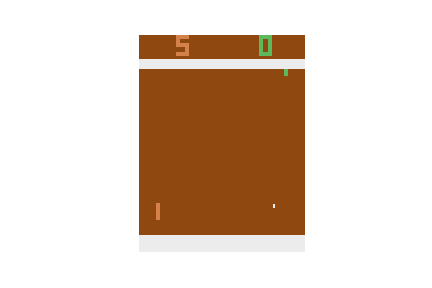
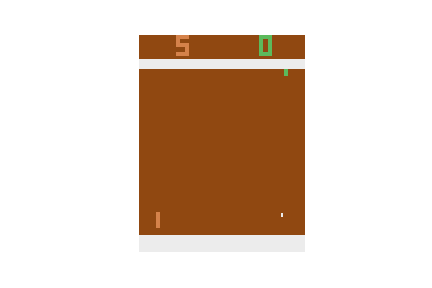
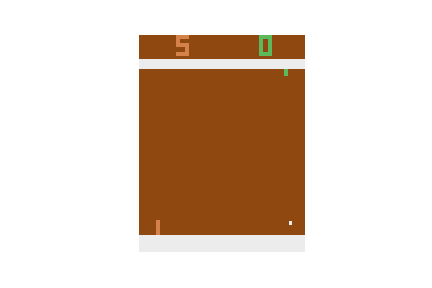
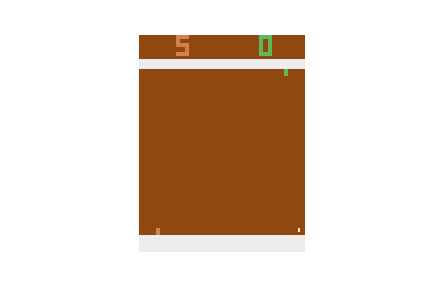
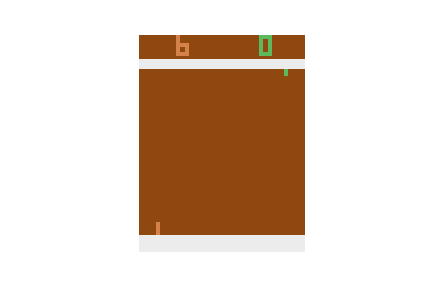
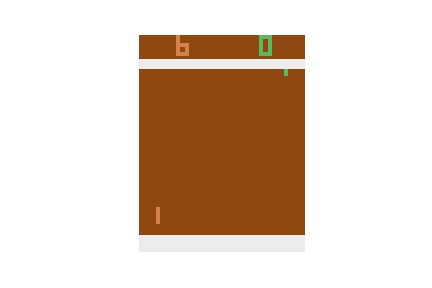
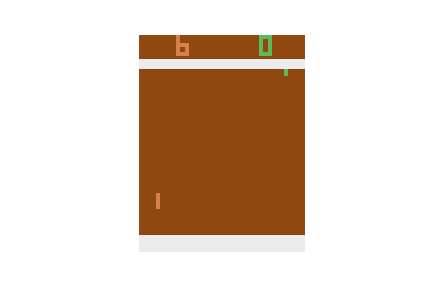
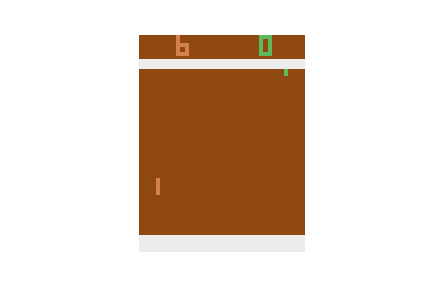
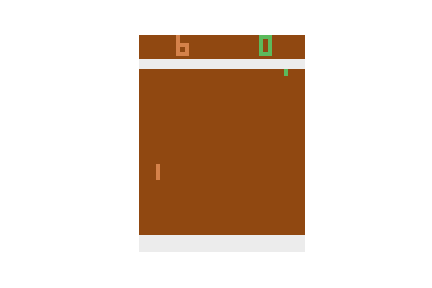
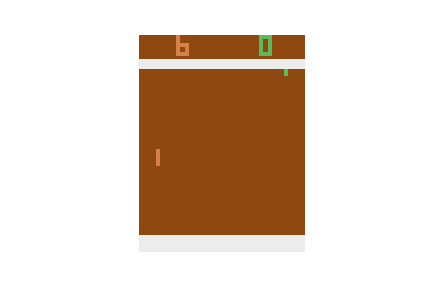
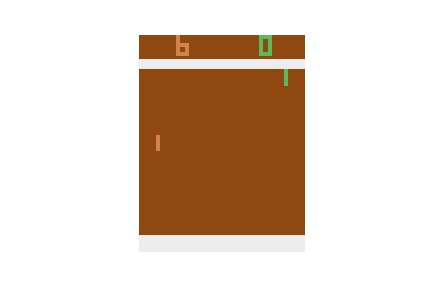
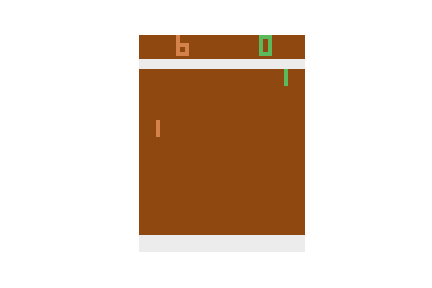
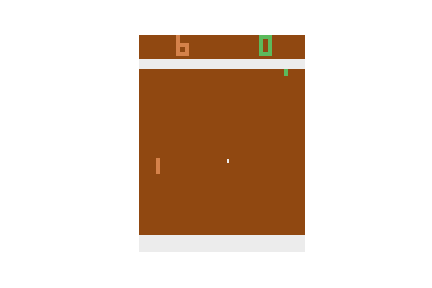
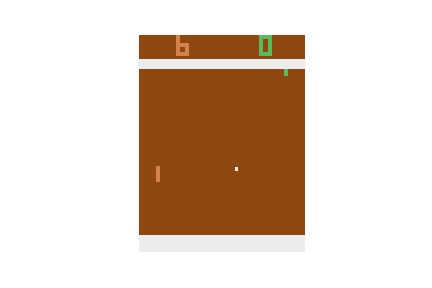
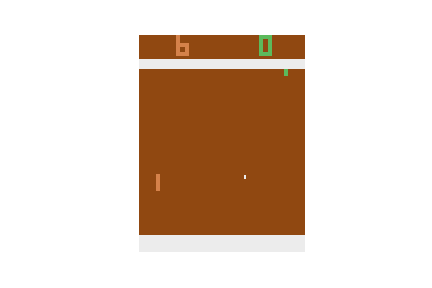
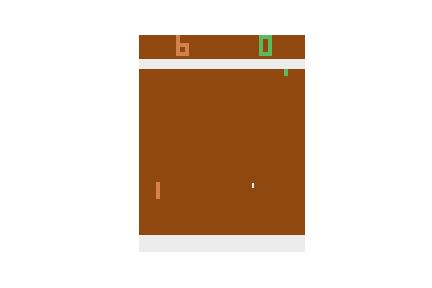
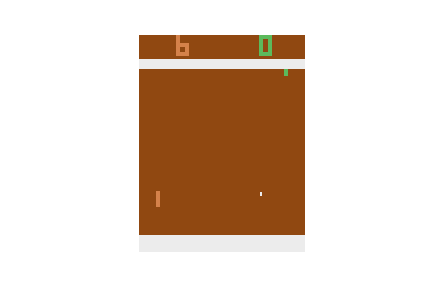
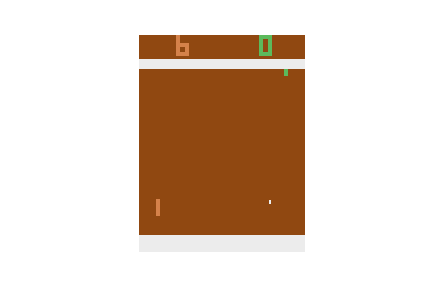
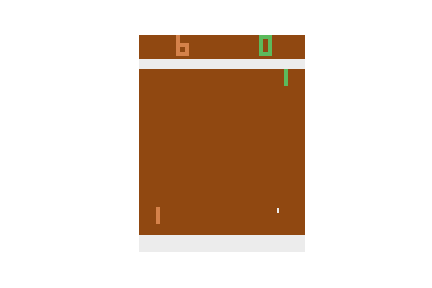
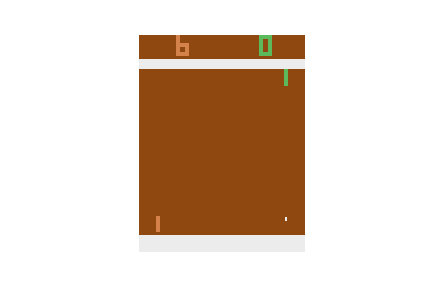
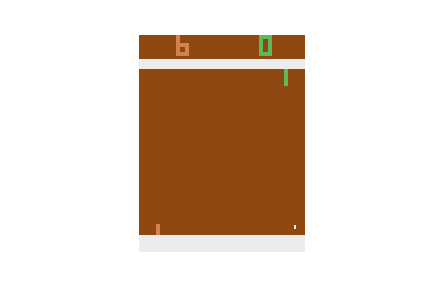
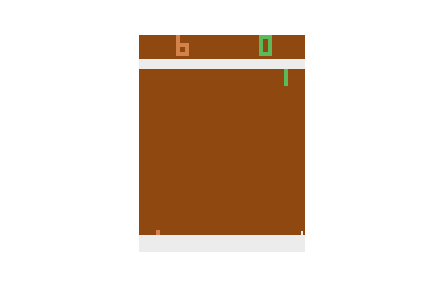
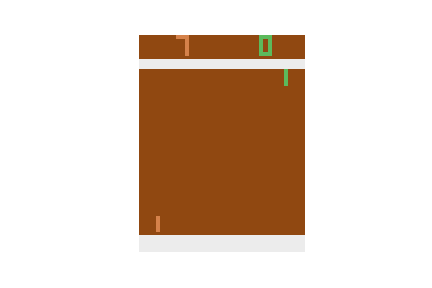
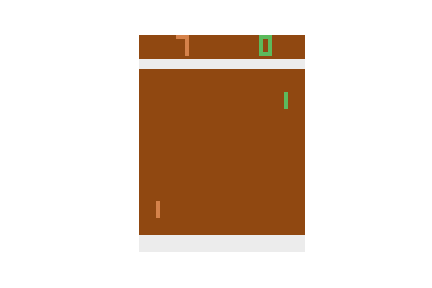
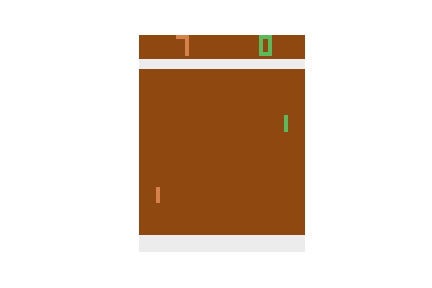
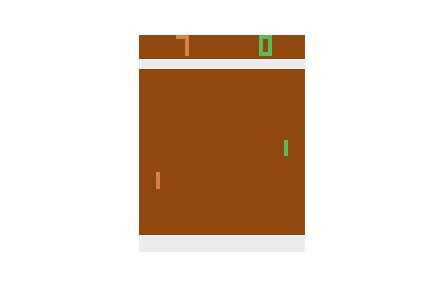
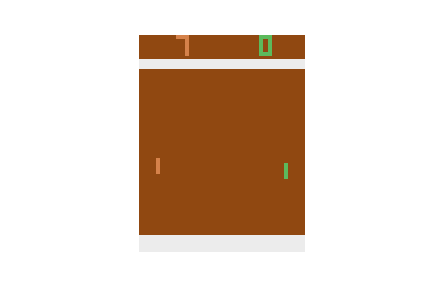
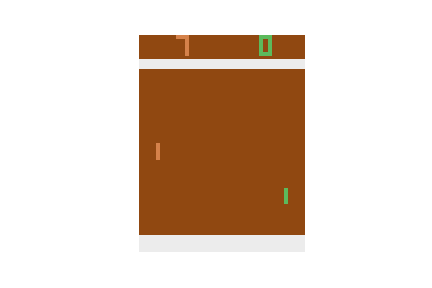
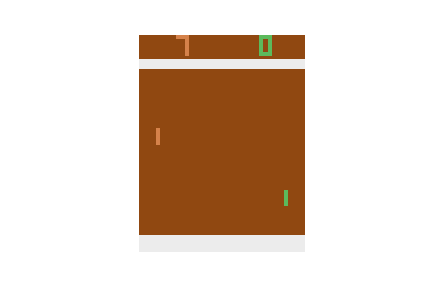
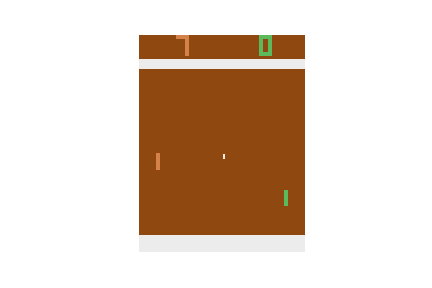
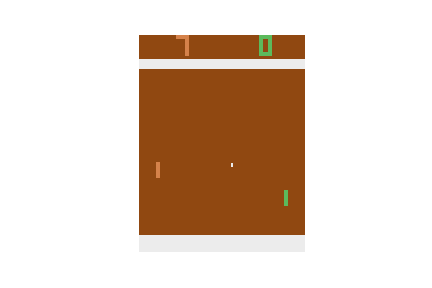
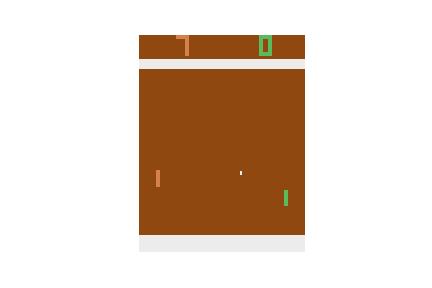
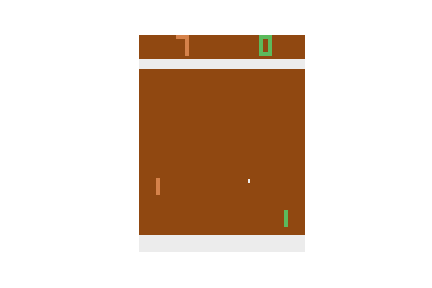
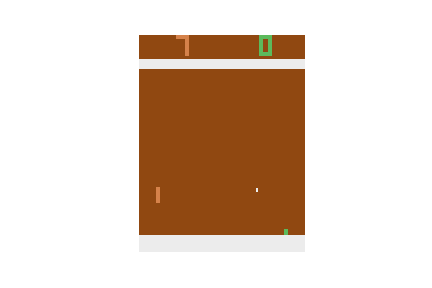
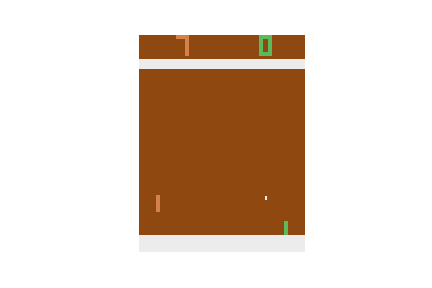
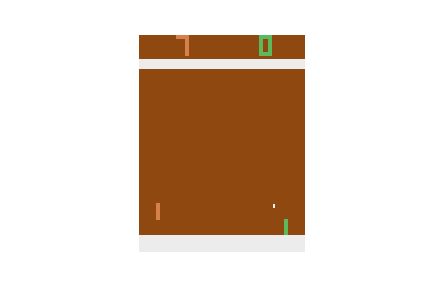
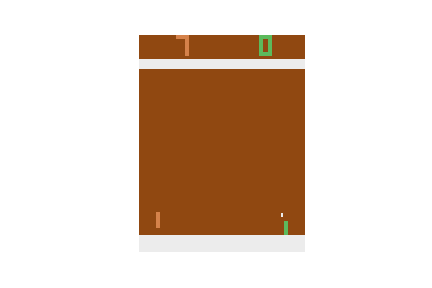
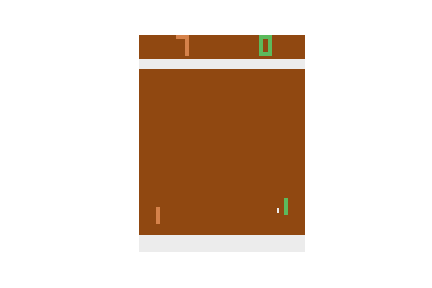
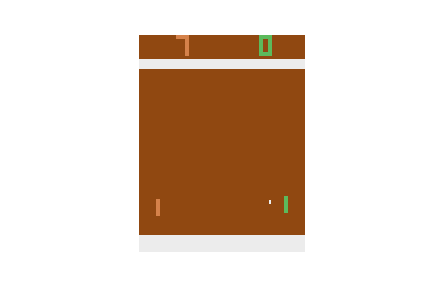
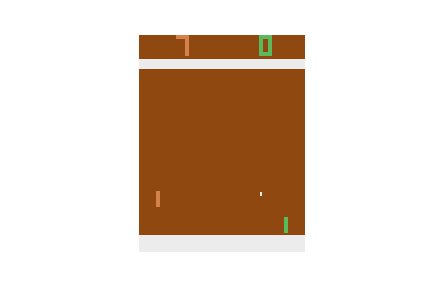
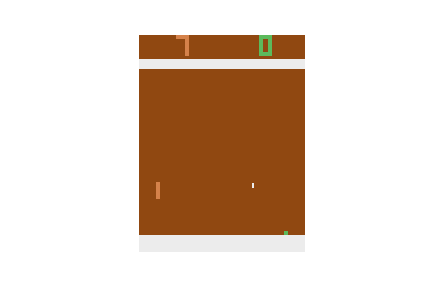
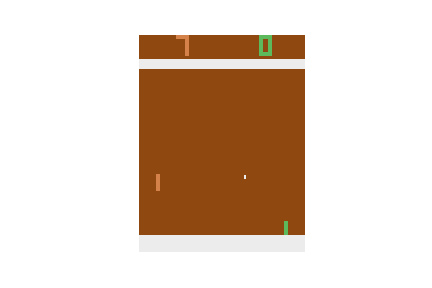
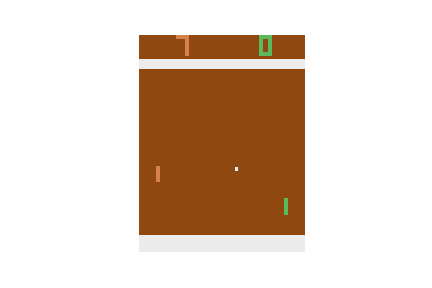
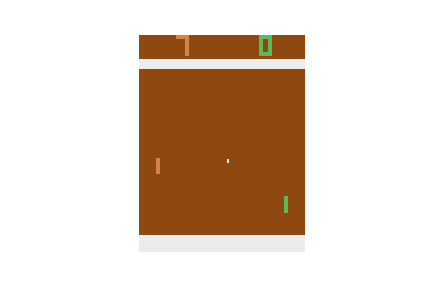
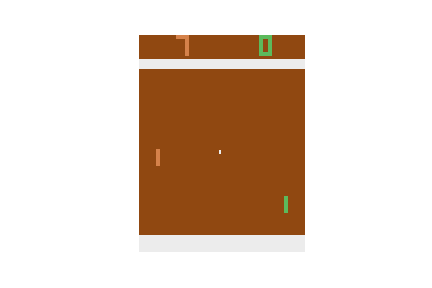
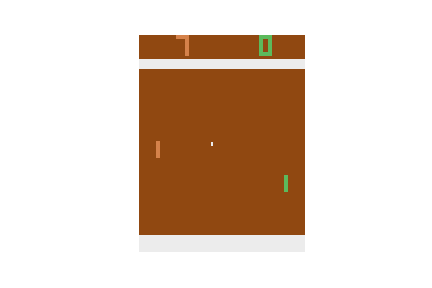
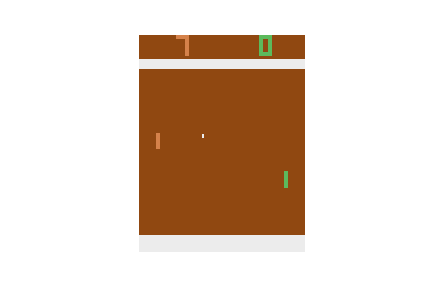
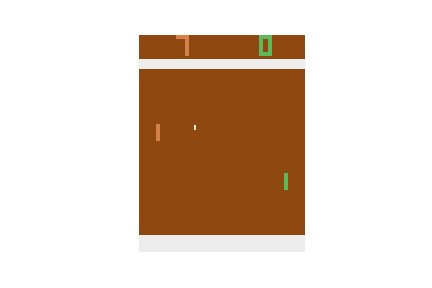
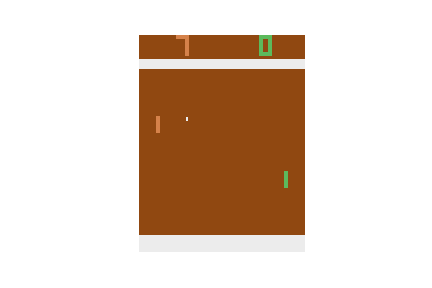
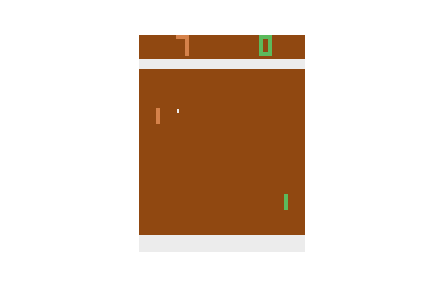
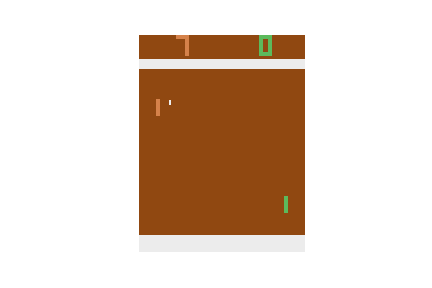
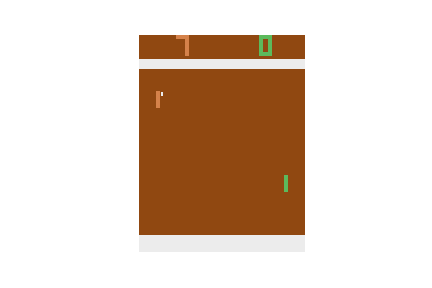
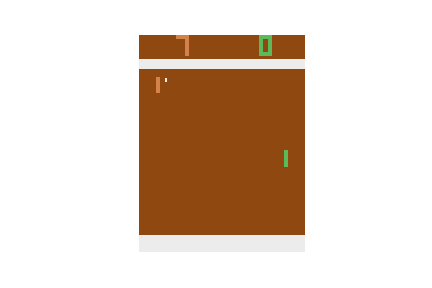
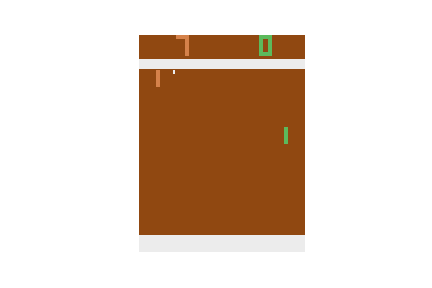
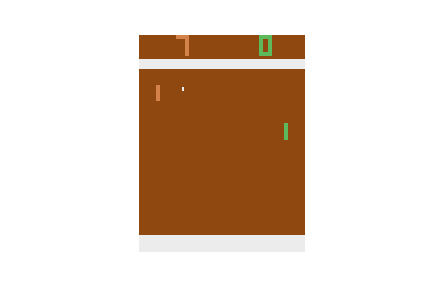
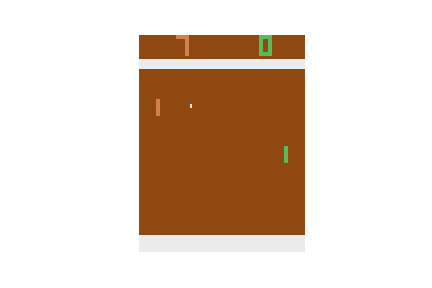
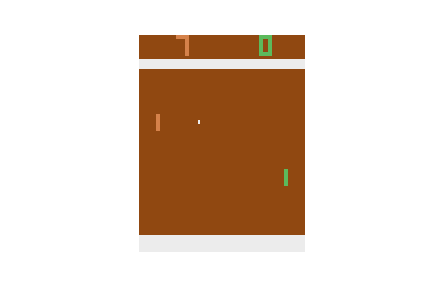
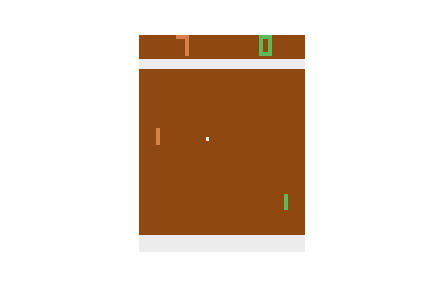
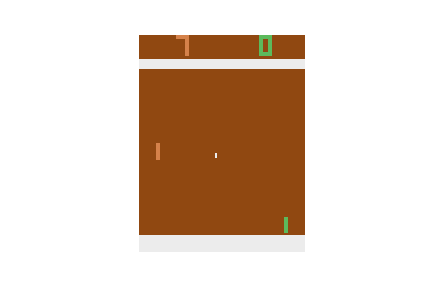
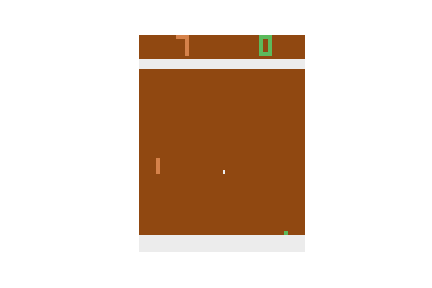
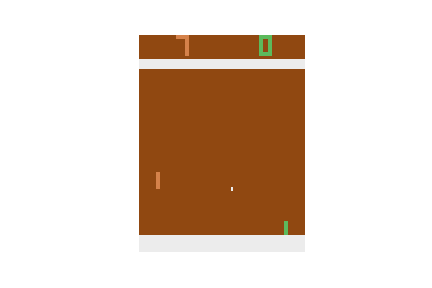
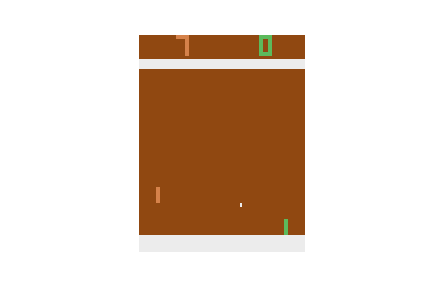
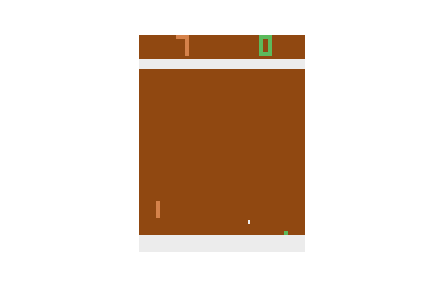
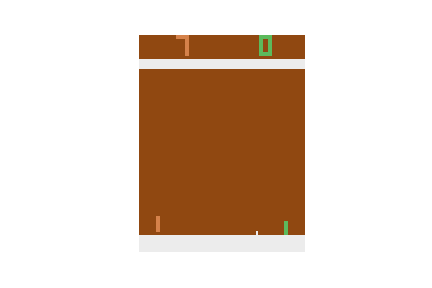
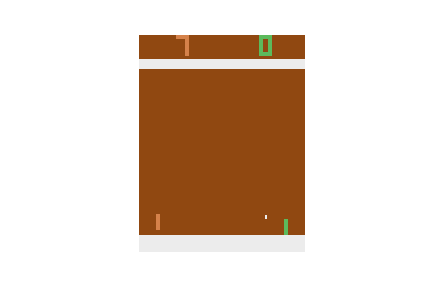
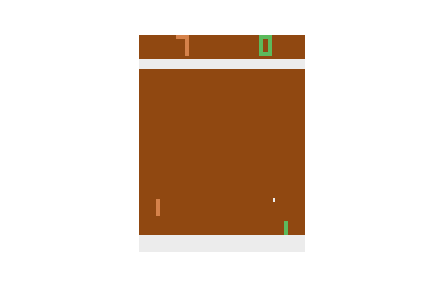
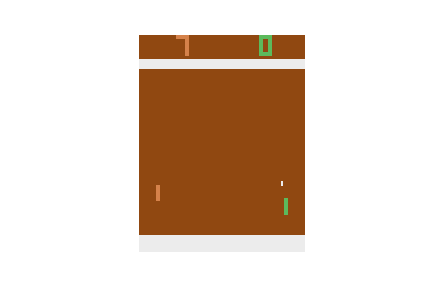
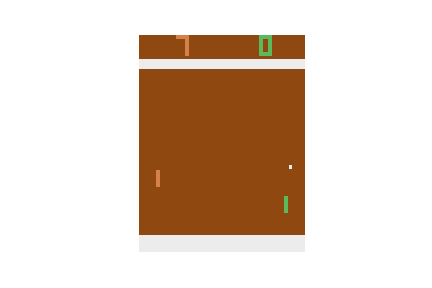
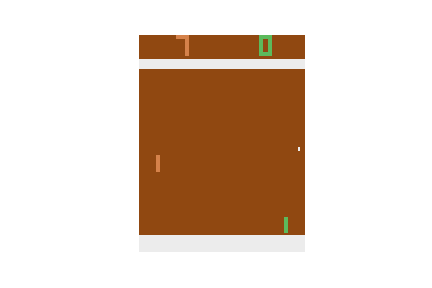
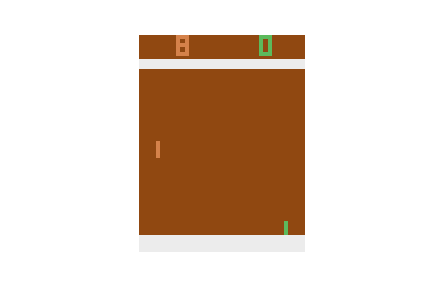
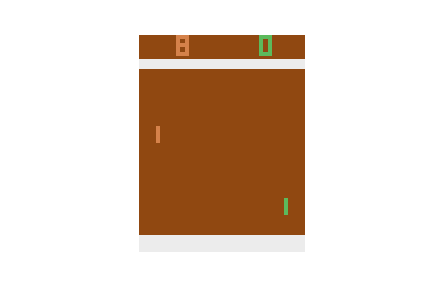
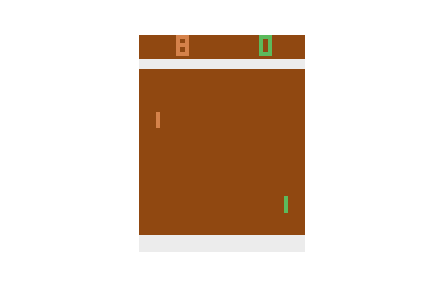
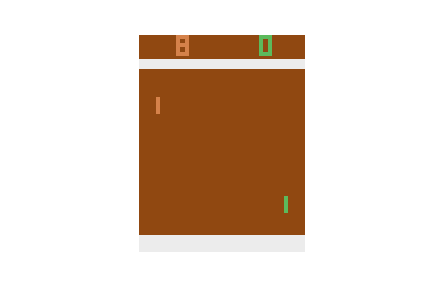
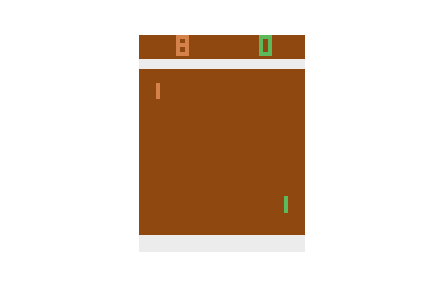
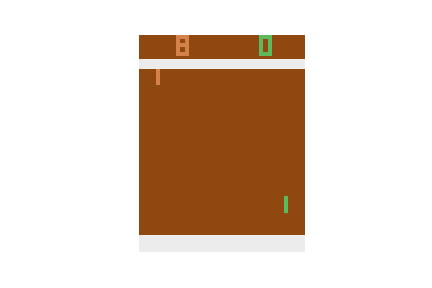
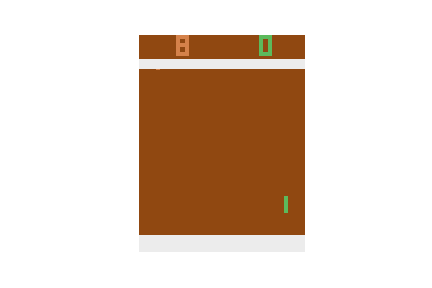
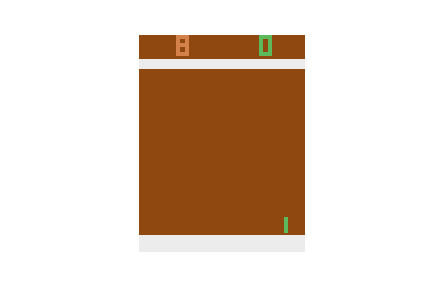
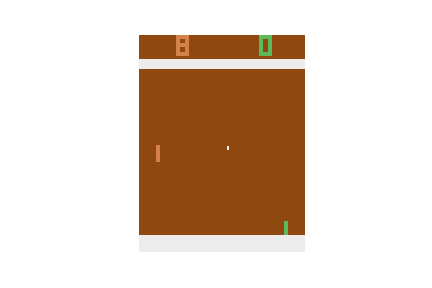
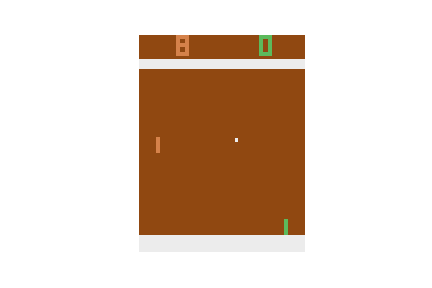
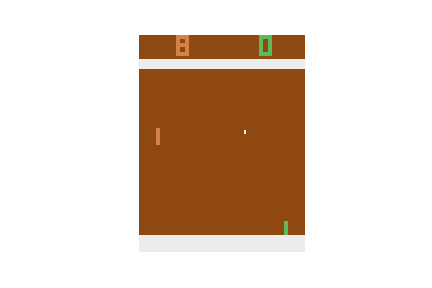
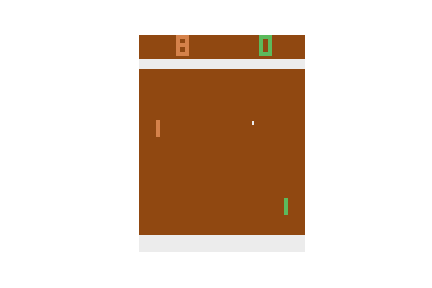
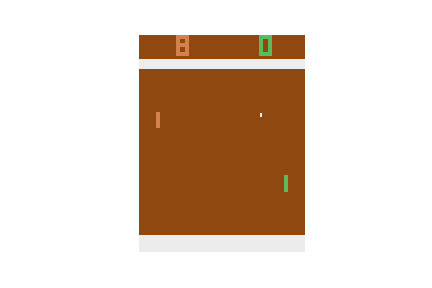
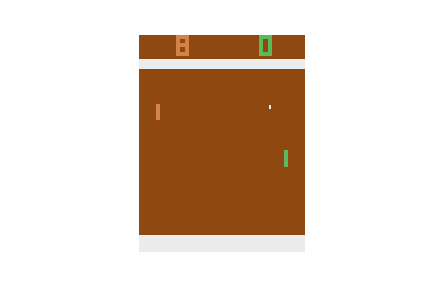
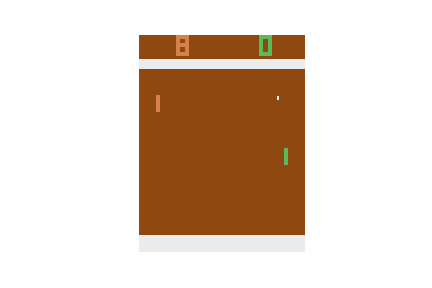
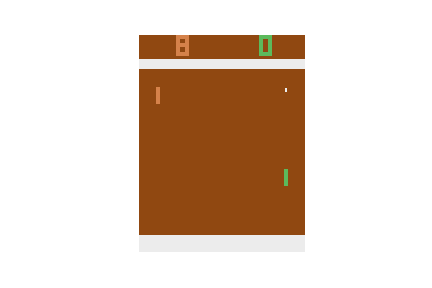
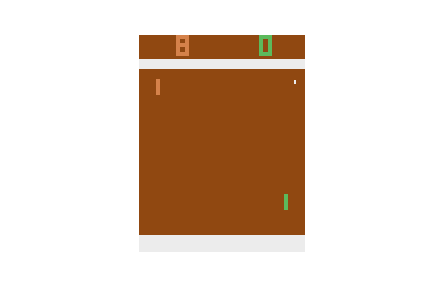
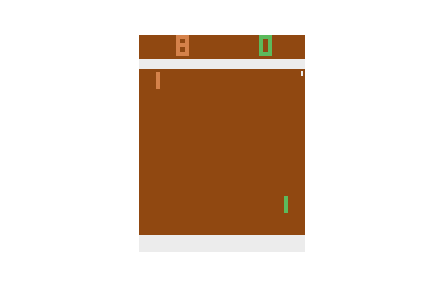
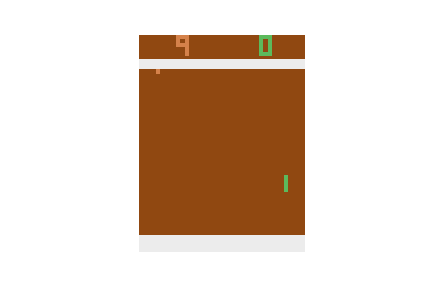
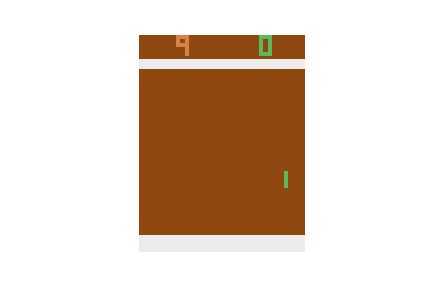
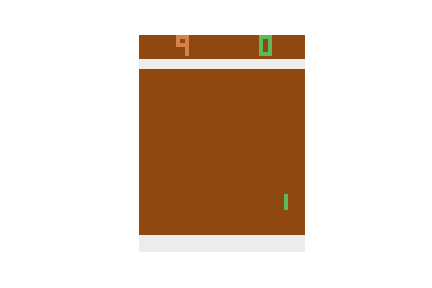

In [5]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [6]:
import torch
epsi = 0.1
tmp = torch.randn((10,4))+1
tmp, torch.clamp(tmp, 1-epsi, 1+epsi), torch.min(tmp, torch.clamp(tmp, 1-epsi, 1+epsi))

(tensor([[ 0.4526,  1.5318,  0.9792,  1.5189],
         [ 1.7361,  2.9545,  0.8942,  0.3557],
         [ 1.6554,  2.0069,  0.7324,  1.7102],
         [ 1.3530,  0.1613,  1.2919,  1.2753],
         [ 0.1502,  2.4887, -0.6650,  1.6054],
         [ 1.4357,  0.2792,  1.8968, -0.6250],
         [ 0.9855,  0.0371,  1.2573,  1.0421],
         [ 1.5786,  0.2489,  0.8370,  2.0826],
         [ 0.5391,  2.0848,  1.3315,  1.2692],
         [-0.1563,  0.0858,  1.6793,  0.1118]]),
 tensor([[ 0.9000,  1.1000,  0.9792,  1.1000],
         [ 1.1000,  1.1000,  0.9000,  0.9000],
         [ 1.1000,  1.1000,  0.9000,  1.1000],
         [ 1.1000,  0.9000,  1.1000,  1.1000],
         [ 0.9000,  1.1000,  0.9000,  1.1000],
         [ 1.1000,  0.9000,  1.1000,  0.9000],
         [ 0.9855,  0.9000,  1.1000,  1.0421],
         [ 1.1000,  0.9000,  0.9000,  1.1000],
         [ 0.9000,  1.1000,  1.1000,  1.1000],
         [ 0.9000,  0.9000,  1.1000,  0.9000]]),
 tensor([[ 0.4526,  1.1000,  0.9792,  1.1000],
         

In [7]:
import numpy as np

def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    
    _eps = 1.e-10
    
    discounts = discount**np.arange(len(rewards))
    rewards_discounted = discount*np.asarray(rewards)
    rewards_future = rewards_discounted[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1).reshape(-1,1)
    std = np.std(rewards_future, axis=1).reshape(-1,1) + _eps
    
    rewards_normalized = (rewards_future-mean)/std
    
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards_future = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    ratio = new_probs/old_probs*rewards_future
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+_eps)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+_eps))

    return torch.mean(torch.min(ratio, torch.clamp(ratio, 1-epsilon, 1+epsilon)) + beta*entropy)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [8]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 1200

# widget bar to display progress
!pip install tqdm
from tqdm import tqdm
#!pip install progressbar
#import progressbar as pb
#widget = ['training loop: ', pb.Percentage(), ' ', 
#          pb.Bar(), ' ', pb.ETA() ]
#timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

from workspace_utils import active_session

with active_session():
    for e in tqdm(range(episode)):

        # collect trajectories
        old_probs, states, actions, rewards = \
            pong_utils.collect_trajectories(envs, policy, tmax=tmax)

        total_rewards = np.sum(rewards, axis=0)


        # gradient ascent step
        for _ in range(SGD_epoch):

            # uncomment to utilize your own clipped function!
            L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

            #L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
            #                                  epsilon=epsilon, beta=beta)
            optimizer.zero_grad()
            L.backward()
            optimizer.step()
            del L

        # the clipping parameter reduces as time goes on
        epsilon*=.999

        # the regulation term also reduces
        # this reduces exploration in later runs
        beta*=.995

        # get the average reward of the parallel environments
        mean_rewards.append(np.mean(total_rewards))

        # display some progress every 20 iterations
        if (e+1)%20 ==0 :
            print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
            print(total_rewards)

        # update progress widget bar
#        timer.update(e+1)

#    timer.finish()

  2%|▏         | 20/1200 [02:05<2:02:26,  6.23s/it]

Episode: 20, score: -15.000000
[-15. -17. -14. -15. -17. -12. -14. -16.]


  3%|▎         | 40/1200 [04:11<2:02:34,  6.34s/it]

Episode: 40, score: -16.000000
[-16. -16. -16. -17. -17. -16. -16. -14.]


  5%|▌         | 60/1200 [06:16<1:57:18,  6.17s/it]

Episode: 60, score: -13.000000
[-12. -12. -12. -15. -10. -13. -16. -14.]


  7%|▋         | 80/1200 [08:23<1:58:08,  6.33s/it]

Episode: 80, score: -13.250000
[-10. -14.  -9. -14. -16. -16. -11. -16.]


  8%|▊         | 100/1200 [10:29<1:56:13,  6.34s/it]

Episode: 100, score: -13.750000
[-11. -15.  -9. -13. -16. -12. -17. -17.]


 10%|█         | 120/1200 [12:37<1:54:28,  6.36s/it]

Episode: 120, score: -15.750000
[-16. -16. -16. -17. -16. -16. -15. -14.]


 12%|█▏        | 140/1200 [14:43<1:51:24,  6.31s/it]

Episode: 140, score: -14.250000
[-12. -15. -16. -12. -16. -14. -14. -15.]


 13%|█▎        | 160/1200 [16:50<1:49:56,  6.34s/it]

Episode: 160, score: -13.750000
[-16. -16. -12. -14. -13. -13. -13. -13.]


 15%|█▌        | 180/1200 [18:54<1:44:38,  6.16s/it]

Episode: 180, score: -15.625000
[-16. -16. -16. -14. -17. -17. -15. -14.]


 17%|█▋        | 200/1200 [21:00<1:45:47,  6.35s/it]

Episode: 200, score: -14.875000
[-12. -15. -16. -16. -15. -16. -15. -14.]


 18%|█▊        | 220/1200 [23:07<1:44:41,  6.41s/it]

Episode: 220, score: -14.625000
[-16. -15. -15. -14. -12. -16. -16. -13.]


 20%|██        | 240/1200 [25:12<1:40:19,  6.27s/it]

Episode: 240, score: -13.500000
[-17.  -8. -17. -12. -17. -15. -12. -10.]


 22%|██▏       | 260/1200 [27:19<1:39:15,  6.34s/it]

Episode: 260, score: -14.375000
[-14. -15. -17. -11. -15. -12. -15. -16.]


 23%|██▎       | 280/1200 [29:25<1:36:10,  6.27s/it]

Episode: 280, score: -14.500000
[-17. -11. -15. -16. -17. -11. -16. -13.]


 25%|██▌       | 300/1200 [31:30<1:34:11,  6.28s/it]

Episode: 300, score: -13.875000
[-15. -17. -10. -16. -14.  -6. -16. -17.]


 27%|██▋       | 320/1200 [33:37<1:32:38,  6.32s/it]

Episode: 320, score: -14.750000
[-16. -15. -16. -13. -14. -16. -15. -13.]


 28%|██▊       | 340/1200 [35:43<1:30:23,  6.31s/it]

Episode: 340, score: -15.250000
[-16. -16. -16. -13. -16. -15. -16. -14.]


 30%|███       | 360/1200 [37:49<1:29:16,  6.38s/it]

Episode: 360, score: -15.000000
[-16. -17. -13. -17. -14. -16. -13. -14.]


 32%|███▏      | 380/1200 [40:00<1:29:59,  6.59s/it]

Episode: 380, score: -14.625000
[-16. -16. -13. -16. -16.  -9. -15. -16.]


 33%|███▎      | 400/1200 [42:07<1:24:06,  6.31s/it]

Episode: 400, score: -12.875000
[-12. -15. -13. -15. -13. -14. -10. -11.]


 35%|███▌      | 420/1200 [44:14<1:22:59,  6.38s/it]

Episode: 420, score: -15.000000
[-16. -17. -15. -14. -16. -15. -13. -14.]


 37%|███▋      | 440/1200 [46:24<1:21:46,  6.46s/it]

Episode: 440, score: -14.750000
[-17. -11. -16. -15. -16. -14. -15. -14.]


 38%|███▊      | 460/1200 [48:33<1:19:15,  6.43s/it]

Episode: 460, score: -14.000000
[-16. -12. -16. -16. -13. -13. -14. -12.]


 40%|████      | 480/1200 [50:42<1:17:53,  6.49s/it]

Episode: 480, score: -14.625000
[-12. -16. -12. -16. -16. -16. -16. -13.]


 42%|████▏     | 500/1200 [52:52<1:14:52,  6.42s/it]

Episode: 500, score: -12.875000
[-10. -14. -15. -10. -14. -16. -10. -14.]


 43%|████▎     | 520/1200 [54:59<1:12:46,  6.42s/it]

Episode: 520, score: -13.625000
[-14. -10. -13. -14. -17. -11. -14. -16.]


 45%|████▌     | 540/1200 [57:09<1:11:15,  6.48s/it]

Episode: 540, score: -14.375000
[-17. -15. -13. -16. -10. -12. -16. -16.]


 47%|████▋     | 560/1200 [59:18<1:08:41,  6.44s/it]

Episode: 560, score: -14.750000
[-16. -11. -11. -13. -17. -16. -17. -17.]


 48%|████▊     | 580/1200 [1:01:27<1:05:58,  6.39s/it]

Episode: 580, score: -15.750000
[-16. -16. -16. -17. -16. -12. -16. -17.]


 50%|█████     | 600/1200 [1:03:37<1:05:10,  6.52s/it]

Episode: 600, score: -13.750000
[-16. -16. -11. -10.  -9. -15. -17. -16.]


 52%|█████▏    | 620/1200 [1:05:44<1:00:44,  6.28s/it]

Episode: 620, score: -14.875000
[-17. -16. -16. -16. -16. -13. -15. -10.]


 53%|█████▎    | 640/1200 [1:07:50<58:40,  6.29s/it]  

Episode: 640, score: -13.750000
[-11.  -9. -13. -16. -16. -13. -16. -16.]


 55%|█████▌    | 660/1200 [1:09:56<56:58,  6.33s/it]

Episode: 660, score: -14.750000
[-15. -17. -16. -16. -16.  -8. -14. -16.]


 57%|█████▋    | 680/1200 [1:12:03<54:39,  6.31s/it]

Episode: 680, score: -13.625000
[-11. -11. -16. -16. -15. -14. -15. -11.]


 58%|█████▊    | 700/1200 [1:14:08<52:09,  6.26s/it]

Episode: 700, score: -13.625000
[-10. -15. -16. -14. -11. -10. -17. -16.]


 60%|██████    | 720/1200 [1:16:14<50:15,  6.28s/it]

Episode: 720, score: -14.375000
[-15. -15. -12. -15. -11. -17. -14. -16.]


 62%|██████▏   | 740/1200 [1:18:19<48:16,  6.30s/it]

Episode: 740, score: -15.375000
[-17. -15. -17. -17. -17. -11. -16. -13.]


 63%|██████▎   | 760/1200 [1:20:25<46:09,  6.29s/it]

Episode: 760, score: -14.250000
[-15. -17. -16. -16. -14.  -5. -14. -17.]


 65%|██████▌   | 780/1200 [1:22:31<44:31,  6.36s/it]

Episode: 780, score: -14.250000
[-13. -14. -17. -15. -13. -14. -12. -16.]


 67%|██████▋   | 800/1200 [1:24:40<43:02,  6.46s/it]

Episode: 800, score: -15.875000
[-16. -17. -14. -16. -16. -16. -16. -16.]


 68%|██████▊   | 820/1200 [1:26:48<40:23,  6.38s/it]

Episode: 820, score: -14.125000
[-15.  -8. -16. -15. -17. -15. -10. -17.]


 70%|███████   | 840/1200 [1:28:57<38:43,  6.45s/it]

Episode: 840, score: -15.500000
[-15. -17. -12. -15. -16. -16. -17. -16.]


 72%|███████▏  | 860/1200 [1:31:05<36:18,  6.41s/it]

Episode: 860, score: -14.125000
[-16. -15. -16. -16. -15. -16.  -9. -10.]


 73%|███████▎  | 880/1200 [1:33:15<35:17,  6.62s/it]

Episode: 880, score: -14.125000
[-16. -13. -17. -15.  -8. -15. -15. -14.]


 75%|███████▌  | 900/1200 [1:35:23<32:11,  6.44s/it]

Episode: 900, score: -13.625000
[ -9. -16. -13. -11. -14. -17. -17. -12.]


 77%|███████▋  | 920/1200 [1:37:30<29:15,  6.27s/it]

Episode: 920, score: -13.250000
[-16.  -5. -15. -17. -15. -15. -12. -11.]


 78%|███████▊  | 940/1200 [1:39:37<27:30,  6.35s/it]

Episode: 940, score: -16.000000
[-16. -17. -16. -16. -16. -15. -16. -16.]


 80%|████████  | 960/1200 [1:41:43<25:10,  6.29s/it]

Episode: 960, score: -13.875000
[-11. -15. -16. -14.  -9. -15. -16. -15.]


 82%|████████▏ | 980/1200 [1:43:47<22:54,  6.25s/it]

Episode: 980, score: -14.750000
[-16. -13. -16. -16. -16. -13. -16. -12.]


 83%|████████▎ | 1000/1200 [1:45:54<21:05,  6.33s/it]

Episode: 1000, score: -15.000000
[-14. -15. -16. -16. -13. -16. -14. -16.]


 85%|████████▌ | 1020/1200 [1:47:59<18:43,  6.24s/it]

Episode: 1020, score: -14.250000
[-16. -13. -11. -15. -12. -16. -14. -17.]


 87%|████████▋ | 1040/1200 [1:50:04<16:41,  6.26s/it]

Episode: 1040, score: -13.375000
[-16. -14. -12.  -8. -12. -16. -14. -15.]


 88%|████████▊ | 1060/1200 [1:52:09<14:37,  6.27s/it]

Episode: 1060, score: -13.875000
[-10. -16. -14. -14. -16. -13. -12. -16.]


 90%|█████████ | 1080/1200 [1:54:16<12:41,  6.34s/it]

Episode: 1080, score: -15.375000
[-17. -15. -17. -16. -14. -11. -16. -17.]


 92%|█████████▏| 1100/1200 [1:56:21<10:25,  6.26s/it]

Episode: 1100, score: -14.250000
[-15. -11. -15. -15. -15. -16. -12. -15.]


 93%|█████████▎| 1120/1200 [1:58:25<08:22,  6.28s/it]

Episode: 1120, score: -14.875000
[-15. -14. -17. -16. -12. -12. -16. -17.]


 95%|█████████▌| 1140/1200 [2:00:31<06:16,  6.27s/it]

Episode: 1140, score: -15.250000
[-14. -16. -15. -16. -12. -16. -16. -17.]


 97%|█████████▋| 1160/1200 [2:02:36<04:13,  6.34s/it]

Episode: 1160, score: -14.000000
[-16. -16. -13. -11. -11. -14. -15. -16.]


 98%|█████████▊| 1180/1200 [2:04:41<02:05,  6.26s/it]

Episode: 1180, score: -15.250000
[-12. -16. -16. -16. -15. -17. -16. -14.]


100%|██████████| 1200/1200 [2:06:45<00:00,  6.24s/it]

Episode: 1200, score: -14.750000
[-14. -13. -15. -16. -15. -16. -17. -12.]


In [ ]:
pong_utils.play(env, policy, time=200) 

In [9]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


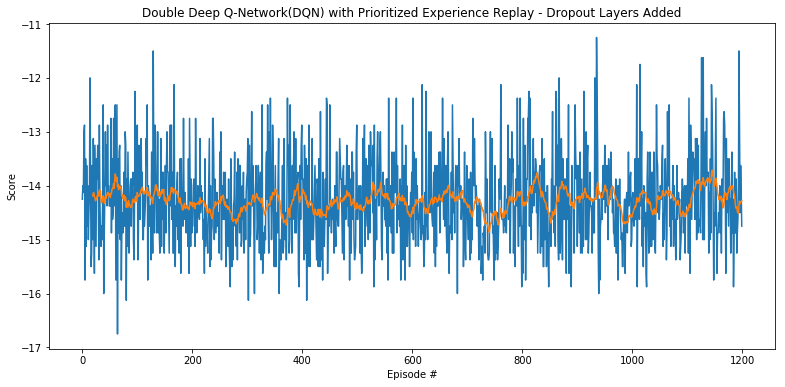

In [10]:
import pandas as pd

rolling_window = 20

fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(mean_rewards)), mean_rewards)
rolling_mean = pd.Series(mean_rewards).rolling(rolling_window).mean()
plt.plot(rolling_mean)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Double Deep Q-Network(DQN) with Prioritized Experience Replay - Dropout Layers Added')
#plt.grid()
plt.show()

In [11]:
with open('scores.txt', 'w') as f:
    f.write(' '.join([str(i) for i in mean_rewards]))